In [15]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import pymorphy2
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ywd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ywd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
morph = pymorphy2.MorphAnalyzer()

def preprocess_text_russian(text):
    text = re.sub(r"[^а-яА-Я]+", " ", text)
    tokens = word_tokenize(text, language='russian')
    filtered_tokens = [morph.parse(word)[0].normal_form for word in tokens if word not in stopwords.words('russian')]
    return filtered_tokens

In [18]:
file_path = 'D:/xuexi/nlp/nlp-2023-master/data/news.txt'  
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

processed_data = []
for line in lines:
    category, title, content = line.split('\t')
    processed_title = preprocess_text_russian(title)
    processed_content = preprocess_text_russian(content)
    full_text = processed_title + processed_content
    processed_data.append((category, full_text))

In [19]:
model = Word2Vec([text for _, text in processed_data], vector_size=100, window=5, min_count=1, workers=4)

In [20]:
def document_vector(doc):
    doc = [word for word in doc if word in model.wv.key_to_index]
    return np.mean(model.wv[doc], axis=0) if doc else np.zeros(model.vector_size)

              precision    recall  f1-score   support

    business       0.48      0.19      0.27        79
     culture       0.85      0.84      0.85       279
   economics       0.73      0.91      0.81       266
      forces       0.74      0.80      0.77       149
        life       0.76      0.81      0.78       288
       media       0.83      0.76      0.79       299
     science       0.85      0.83      0.84       288
       sport       0.96      0.96      0.96       276
       style       0.94      0.76      0.84        38
      travel       0.53      0.47      0.50        38

    accuracy                           0.81      2000
   macro avg       0.77      0.73      0.74      2000
weighted avg       0.81      0.81      0.80      2000



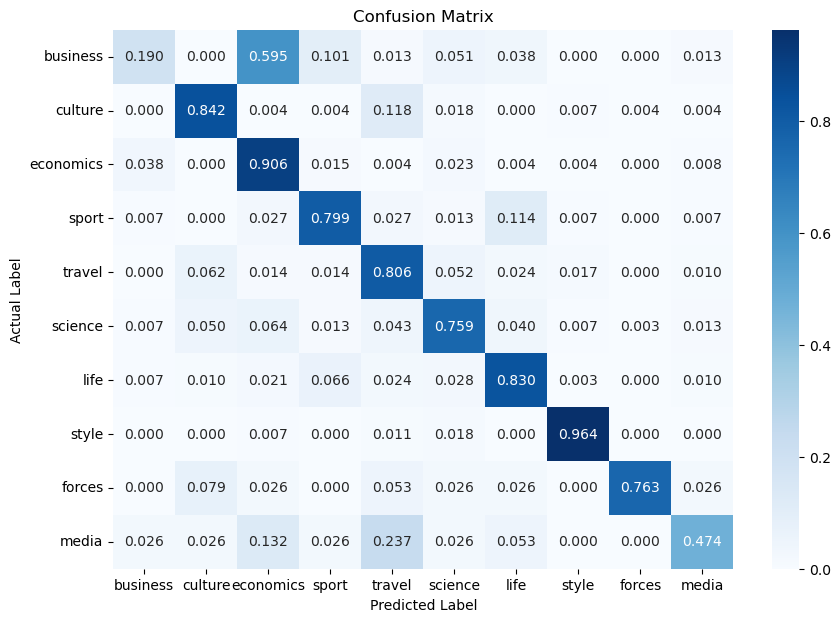

In [21]:
X = [document_vector(text) for _, text in processed_data]
y = [category for category, _ in processed_data]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
categories = set([category for category, _ in processed_data])
class_names = list(categories)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".3f",cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")

plt.show()

              precision    recall  f1-score   support

    business       0.48      0.35      0.41        79
     culture       0.87      0.87      0.87       279
   economics       0.77      0.87      0.82       266
      forces       0.76      0.82      0.79       149
        life       0.79      0.81      0.80       288
       media       0.84      0.77      0.81       299
     science       0.84      0.83      0.83       288
       sport       0.96      0.97      0.96       276
       style       0.97      0.76      0.85        38
      travel       0.60      0.63      0.62        38

    accuracy                           0.82      2000
   macro avg       0.79      0.77      0.78      2000
weighted avg       0.82      0.82      0.82      2000



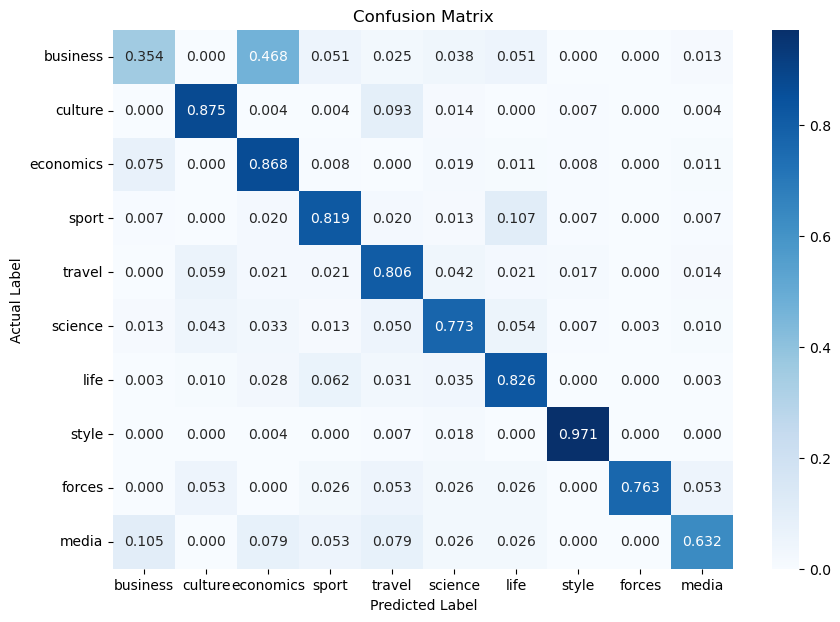

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

corpus = [" ".join(text) for _, text in processed_data]

tfidf = TfidfVectorizer()
tfidf.fit(corpus)
max_idf = max(tfidf.idf_)
word2weight = defaultdict(lambda: max_idf, [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

def document_vector_tfidf(doc):
    doc = [word for word in doc if word in model.wv.key_to_index]
    word_vectors = [model.wv[word] * word2weight[word] for word in doc]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

X = [document_vector_tfidf(text) for _, text in processed_data]
y = [category for category, _ in processed_data]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".3f",cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")

plt.show()


              precision    recall  f1-score   support

    business       0.68      0.51      0.58        79
     culture       0.91      0.90      0.91       279
   economics       0.84      0.92      0.87       266
      forces       0.83      0.84      0.83       149
        life       0.79      0.85      0.82       288
       media       0.86      0.80      0.83       299
     science       0.87      0.85      0.86       288
       sport       0.96      0.98      0.97       276
       style       0.91      0.76      0.83        38
      travel       0.78      0.82      0.79        38

    accuracy                           0.86      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.86      0.86      0.86      2000



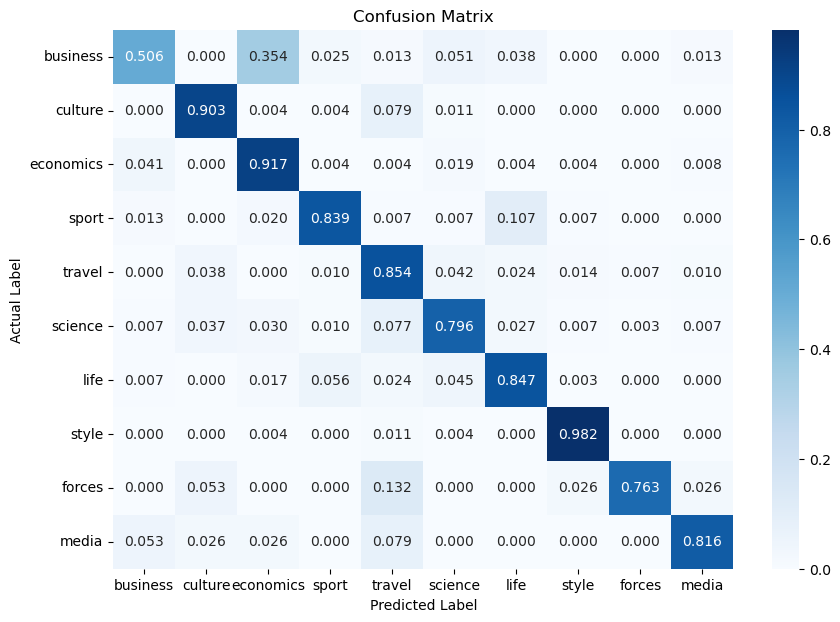

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [" ".join(text) for _, text in processed_data]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
y = [category for category, _ in processed_data]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt=".3f",cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")

plt.show()
